In [1]:
import numpy as np
import pandas as pd
# import cvxpy as cvx
from scipy.optimize import minimize
import sympy as sp
import matplotlib.pyplot as plt
import sympy as sp
from functools import reduce
from mpl_toolkits import mplot3d
from scipy.ndimage.interpolation import shift

%matplotlib notebook

# Implementar algoritmos 5.1, 5.2, algo do prob. 5.15

### 5.7

$$ f(x) = (x_1^2 + x_2^2 - 1)^2 + (x_1 + x_2 -1)^2 $$

<IPython.core.display.Javascript object>


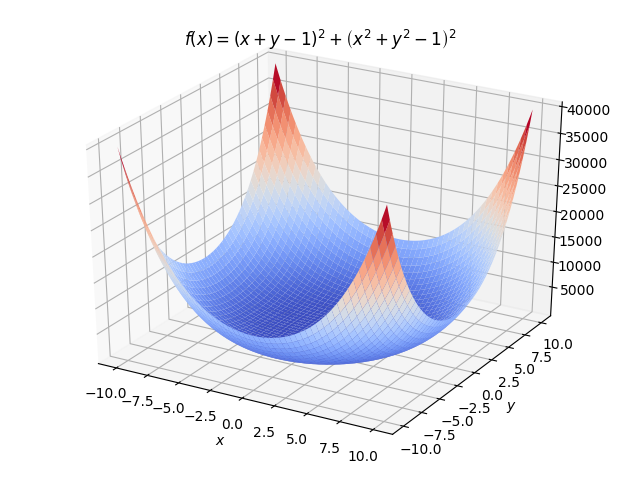

In [16]:
def loss1(x):
    return (x[0]**2 + x[1]**2 -1)**2 + (x[0] + x[1] -1)**2

nbDims = 2
symbolVec = sp.symbols('a0:%d'%nbDims)
cost = sp.lambdify(symbolVec, loss1(symbolVec), modules=['numpy'])
gradCost = sp.lambdify(symbolVec,[sp.diff(loss1(symbolVec),var) for var in (symbolVec)],'numpy')
hessianCost = sp.lambdify(symbolVec, sp.hessian(loss1(symbolVec),symbolVec),'numpy')

domain = np.linspace(-10, 10,500)
X, Y = np.meshgrid(domain, domain)
Z = cost(X,Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z, cmap=plt.cm.coolwarm)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_title('$f(x)=%s$' % sp.latex(loss1(sp.symbols('x y'))));
plt.tight_layout()
# plt.savefig("lista2/relatorio/figs/loss4.eps", 
# #                bbox_inches='tight', 
# #                transparent=True,
#                pad_inches=0)


In [4]:
def generalDescentMethod(x0, costSymbolic, specificDescentMethod, eps=1e-6, **args):
    
    symbolVec = sp.symbols('a0:%d'%len(x0))
    descentAlgo = specificDescentMethod(symbolVec, costSymbolic, **args)
    nbEvalDict = {}
    params = {}
    step = np.inf
    xHist = [x0]
    fxHist = [np.NaN]
    
    while np.linalg.norm(step) > eps:
        
        step, fx, partialNbEvalDict, params = descentAlgo(x0, params)
        nbEvalDict = { k: nbEvalDict.get(k, 0) + partialNbEvalDict.get(k, 0) for k in set(partialNbEvalDict) }
        x0 += step
        xHist.append(x0)
        fxHist.append(fx)
        
    return xHist, fxHist, nbEvalDict

In [17]:
def steepestDescent(symbolVec, costSymbolic, **args):

    cost = sp.lambdify(symbolVec, costSymbolic(symbolVec), modules=['numpy'])
    gradCost = sp.lambdify(symbolVec,[sp.diff(costSymbolic(symbolVec),var) for var in (symbolVec)],'numpy')
    hessianCost = sp.lambdify(symbolVec, sp.hessian(costSymbolic(symbolVec),symbolVec),'numpy')
    lineSearchMethod = args.pop('lineSearchMethod', noLineSearch)

    def steepestDescentAlgo(x0, params):

        dfx = np.asarray(gradCost(*x0))
        direction = -dfx
        t,f, nbEval, newParams = lineSearchMethod(x0, dfx, direction, cost, params, **args)
        step = t*direction

        return step, f, {'nbFuncEval': nbEval, 'nbGradEval':1}, newParams

    return steepestDescentAlgo

In [35]:
def NewtonDescent(symbolVec, costSymbolic, **args):

    cost = sp.lambdify(symbolVec, costSymbolic(symbolVec), modules=['numpy'])
    gradCost = sp.lambdify(symbolVec,[sp.diff(costSymbolic(symbolVec),var) for var in (symbolVec)],'numpy')
    hessianCost = sp.lambdify(symbolVec, sp.hessian(costSymbolic(symbolVec),symbolVec),'numpy')
    lineSearchMethod = args.pop('lineSearchMethod', noLineSearch)
    beta = args.pop('beta', 0.3)

    def BasicNewtonAlgo(x0, params):

        dfx = np.asarray(gradCost(*x0))
        Hx = np.asarray(hessianCost(*x0))
        eigVals = np.linalg.eigvals(Hx)
        minVal = np.min(eigVals)
        if np.any(eigVals < 0.1):
            beta = 1.5*np.abs(np.min(eigVals))
            Hx = (Hx + beta*np.eye(Hx.shape[0]))/(1+beta)

        HxInv = np.linalg.inv(Hx)
        direction = -HxInv.dot(dfx)        
        t,f, nbEval, newParams = lineSearchMethod(x0, dfx, direction, cost, params, **args)
        step = t*direction

        return step, f, {'nbFunEval': nbEval, 'nbGradEval':1, 'nbHessEval':1}, newParams

    return BasicNewtonAlgo

In [6]:
def noLineSearch(x, dfx, vec, cost, params, **args):

    alphaHat = params.pop('alpha', 1)
    fxk = params.pop('fxk', None)
    nbEval = 0
    if fxk is None:
        fxk = cost(*x)
        nbEval += 1
    
    fHat = cost(*(x + alphaHat*vec))
    dfx2alpha = np.inner(dfx,dfx)*alphaHat
    alpha = (dfx2alpha*alphaHat)/(2*(fHat - fxk + dfx2alpha))
    fx = cost(*(x + alpha*vec))
    
    return alpha, fx, nbEval+2, {'alpha': alpha, 'fxk': fx}
    

In [7]:
def backtrackingLineSearch(x, dfx, vec, cost, params, **args):
    
    domain = args.pop('domain', None)
    alpha = args.pop('alpha', 0.15)
    beta = args.pop('beta', 0.5)
    
    t = 1
    nbEval = 2
    fx = cost(*x)
    
    if domain is not None:
        while (x + t*vec <= domain[0]) or (domain[1] <= x + t*vec):
            ptiny
            t *= beta

    f = cost(*(x + t*vec))
    while f > (fx + alpha*t*np.inner(dfx,vec)):
        t *= beta
        f = cost(*(x + t*vec))
        nbEval += 1

    return t,f, nbEval, {}

In [31]:
x0s = np.array(((4.0,4.0), (4.0,-4.0), (-4.0,4.0), (-4.0,-4.0)))
xHist = {}
fxHist = {}
nbEvalList = {}

print('Using algo 5.1')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss1, steepestDescent,
                                                          lineSearchMethod=backtrackingLineSearch,alpha=0.01,beta=0.3)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)

Using algo 5.1

[ 4.  4.]
x min [ 0.62996042  0.62996042]
f(x min) 0.110118425158
nb evals {'nbGradEval': 10, 'nbFuncEval': 41}

[ 4. -4.]
x min [  6.77192177e-07   9.99999811e-01]
f(x min) 3.81285180688e-13
nb evals {'nbGradEval': 35, 'nbFuncEval': 112}

[-4.  4.]
x min [  9.99999811e-01   6.77192177e-07]
f(x min) 3.81285180706e-13
nb evals {'nbGradEval': 35, 'nbFuncEval': 112}

[-4. -4.]
x min [ 0.62996049  0.62996049]
f(x min) 0.110118425158
nb evals {'nbGradEval': 9, 'nbFuncEval': 37}


In [32]:
x0s = np.array(((4.0,4.0), (4.0,-4.0), (-4.0,4.0), (-4.0,-4.0)))
xHist = {}
fxHist = {}
nbEvalList = {}

print('Using algo 5.2')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss1, steepestDescent,
                                                          lineSearchMethod=noLineSearch)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)

Using algo 5.2

[ 4.  4.]
x min [ 0.62996052  0.62996052]
f(x min) 0.110118425158
nb evals {'nbGradEval': 9, 'nbFuncEval': 19}

[ 4. -4.]
x min [  1.00000064e+00  -1.47046618e-06]
f(x min) 2.32582635969e-12
nb evals {'nbGradEval': 45, 'nbFuncEval': 91}

[-4.  4.]
x min [ -1.47046618e-06   1.00000064e+00]
f(x min) 2.32582636114e-12
nb evals {'nbGradEval': 45, 'nbFuncEval': 91}

[-4. -4.]
x min [ 0.62996052  0.62996052]
f(x min) 0.110118425158
nb evals {'nbGradEval': 16, 'nbFuncEval': 33}


In [30]:
x0s = np.array(((4.0,4.0), (4.0,-4.0), (-4.0,4.0), (-4.0,-4.0)))
xHist = {}
fxHist = {}
nbEvalList = {}

print('Using Hessian modified algo 5.3')
for x0 in x0s:
    print()
    print(x0)
    xHist, fxHist, nbEvalList = generalDescentMethod(x0, loss1, NewtonDescent,
                                                          lineSearchMethod=backtrackingLineSearch)
    print('x min', xHist[-1])
    print('f(x min)', fxHist[-1])
    print('nb evals',nbEvalList)

Using Hessian modified algo 5.3

[ 4.  4.]
x min [ 0.62996053  0.62996053]
f(x min) 0.110118425158
nb evals {'nbFunEval': 24, 'nbHessEval': 10, 'nbGradEval': 10}

[ 4. -4.]
x min [  1.00000000e+00  -1.61197095e-17]
f(x min) 2.59845033851e-34
nb evals {'nbFunEval': 22, 'nbHessEval': 11, 'nbGradEval': 11}

[-4.  4.]
x min [ -4.95073114e-17   1.00000000e+00]
f(x min) 0.0
nb evals {'nbFunEval': 22, 'nbHessEval': 11, 'nbGradEval': 11}

[-4. -4.]
x min [ 0.62996053  0.62996052]
f(x min) 0.110118425158
nb evals {'nbFunEval': 27, 'nbHessEval': 11, 'nbGradEval': 11}
